## Imports

In [1]:
import os
import sys
import pathlib
import warnings
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import seaborn as sns

import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from llmicl.interfaces import trainers
from llmicl.rl_helpers import nn_utils

from sklearn.linear_model import LinearRegression

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


## states and actions names

In [2]:
state_names = {
    "HalfCheetah": [
        "rootx",
        "rootz",
        "rooty",
        "bthigh",
        "bshin",
        "bfoot",
        "fthigh",
        "fshin",
        "ffoot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "bthigh_dot",
        "bshin_dot",
        "bfoot_dot",
        "fthigh_dot",
        "fshin_dot",
        "ffoot_dot",
    ],
    "Hopper": [
        "rootx",
        "rootz",
        "rooty",
        "thigh",
        "leg",
        "foot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_dot",
        "leg_dot",
        "foot_dot",
    ]
}
action_names = {
    "HalfCheetah": [
        "t_bthigh",
        "t_bshin",
        "t_bfoot",
        "t_fthigh",
        "t_fshin",
        "t_ffoot",
    ],
    "Hopper": [
        "thigh_joint",
        "leg_joint",
        "foot_joint",
    ]
}

# Helpers

## load model and tokenizer

In [3]:
import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    device_map="auto",   
    torch_dtype=torch.bfloat16, 
)
print(f"finish loading model")
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


finish loading tokenizer


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

## policy classes

In [4]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.single_action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean, std

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env
    return thunk

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class PPOAgent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return (
            action,
            probs.log_prob(action).sum(1),
            probs.entropy().sum(1),
            self.critic(x),
            action_mean,
            action_std
        )

class TD3Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias

## mujoco set and get state

In [5]:
# Extract the state from the MuJoCo model and data
def get_mujoco_state(env):
    model = env.unwrapped.model
    data = env.unwrapped.data
    state = {
        'qpos': data.qpos.copy(),
        'qvel': data.qvel.copy(),
        'act': data.act.copy(),
        'ctrl': data.ctrl.copy(),
        'mocap_pos': data.mocap_pos.copy(),
        'mocap_quat': data.mocap_quat.copy(),
        'userdata': data.userdata.copy(),
        'time': data.time,
    }
    return state

# Set the state back into the MuJoCo model and data
def set_mujoco_state(env, state):
    data = env.unwrapped.data
    data.qpos[:] = state['qpos']
    data.qvel[:] = state['qvel']
    data.act[:] = state['act']
    data.ctrl[:] = state['ctrl']
    data.mocap_pos[:] = state['mocap_pos']
    data.mocap_quat[:] = state['mocap_quat']
    data.userdata[:] = state['userdata']
    data.time = state['time']
    mujoco.mj_forward(env.unwrapped.model, data)

# Generate data

## load env, actor, data

In [6]:
env_name = "HalfCheetah"
env = gym.make(env_name)
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]
algorithm = "td3"  # sac, ppo, td3

# policy_path = "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__ppo_checkpoints__7__1724072335"
# policy_path = "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__sac_continuous_action__1__1723208574"
# policy_path = "/home/abenechehab/cleanrl/runs/Hopper-v4__sac_continuous_action__1__1723453251"
policy_path = "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__td3__1__1723562307"

# policy_checkpoint_list = [10000, 20000, 30000, 40000, 80000, 350000, 700000, 990000]
# policy_checkpoint_list = np.arange(10000, 990000, 10000)
policy_checkpoint = 990000

# load some data to get a pool of states
data_label = "expert"
data_path = f"/home/abenechehab/datasets/{env_name}/{data_label}/X_test.csv"
X = pd.read_csv(data_path, index_col=0)
X = X.values.astype('float')

# find episodes beginnings
restart_index = n_observations+n_actions+1
restarts = X[:, restart_index+1]
episode_starts = np.where(restarts)[0]

# load actor
envs = gym.vector.SyncVectorEnv([make_env(env_name, seed=7, idx=0, capture_video=False, run_name="")])
if algorithm=='sac':
    actor = Actor(envs).to(device)
    actor.load_state_dict(torch.load(f"{policy_path}/actor_checkpoint_{policy_checkpoint}.pth"))
elif algorithm=='td3':
    actor = TD3Actor(envs).to(device)
    actor.load_state_dict(torch.load(f"{policy_path}/actor_checkpoint_{policy_checkpoint}.pth"))
else:
    actor = PPOAgent(envs).to(device)
    actor.load_state_dict(torch.load(f"{policy_path}/agent_checkpoint_{policy_checkpoint}.pth"))
actor.eval()

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(
/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


TD3Actor(
  (fc1): Linear(in_features=17, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=6, bias=True)
)

# ICL

In [8]:
context_length = 500
rescale_factor = 7.0
up_shift = 1.5

icl_objects_list = []

print(f"episode starts: {episode_starts}")

for episode in tqdm(episode_starts, desc='episode'):
    time_series = X[episode:episode+context_length, :n_observations]
    
    trainer = trainers.RLICLTrainer(
        model=model,
        tokenizer=tokenizer,
        n_observations=n_observations,
        n_actions=n_actions,
        rescale_factor=rescale_factor,
        up_shift=up_shift,
    )
    
    trainer.update_context(
        time_series=copy.copy(time_series),
        mean_series=copy.copy(time_series),
        sigma_series=np.zeros_like(time_series),
        context_length=context_length,
        update_min_max=True,
    )
    
    trainer.icl(verbose=0, stochastic=True)
    
    icl_objects_list.append(trainer.compute_statistics())

episode starts: [    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000]


episode:   0%|                                                                                                    | 0/19 [00:00<?, ?it/s]/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:446: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr
episode: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 19/19 [14:33<00:00, 45.99s/it]


# Error plots

## llm alone

episode: 100%|███████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181530.24it/s]


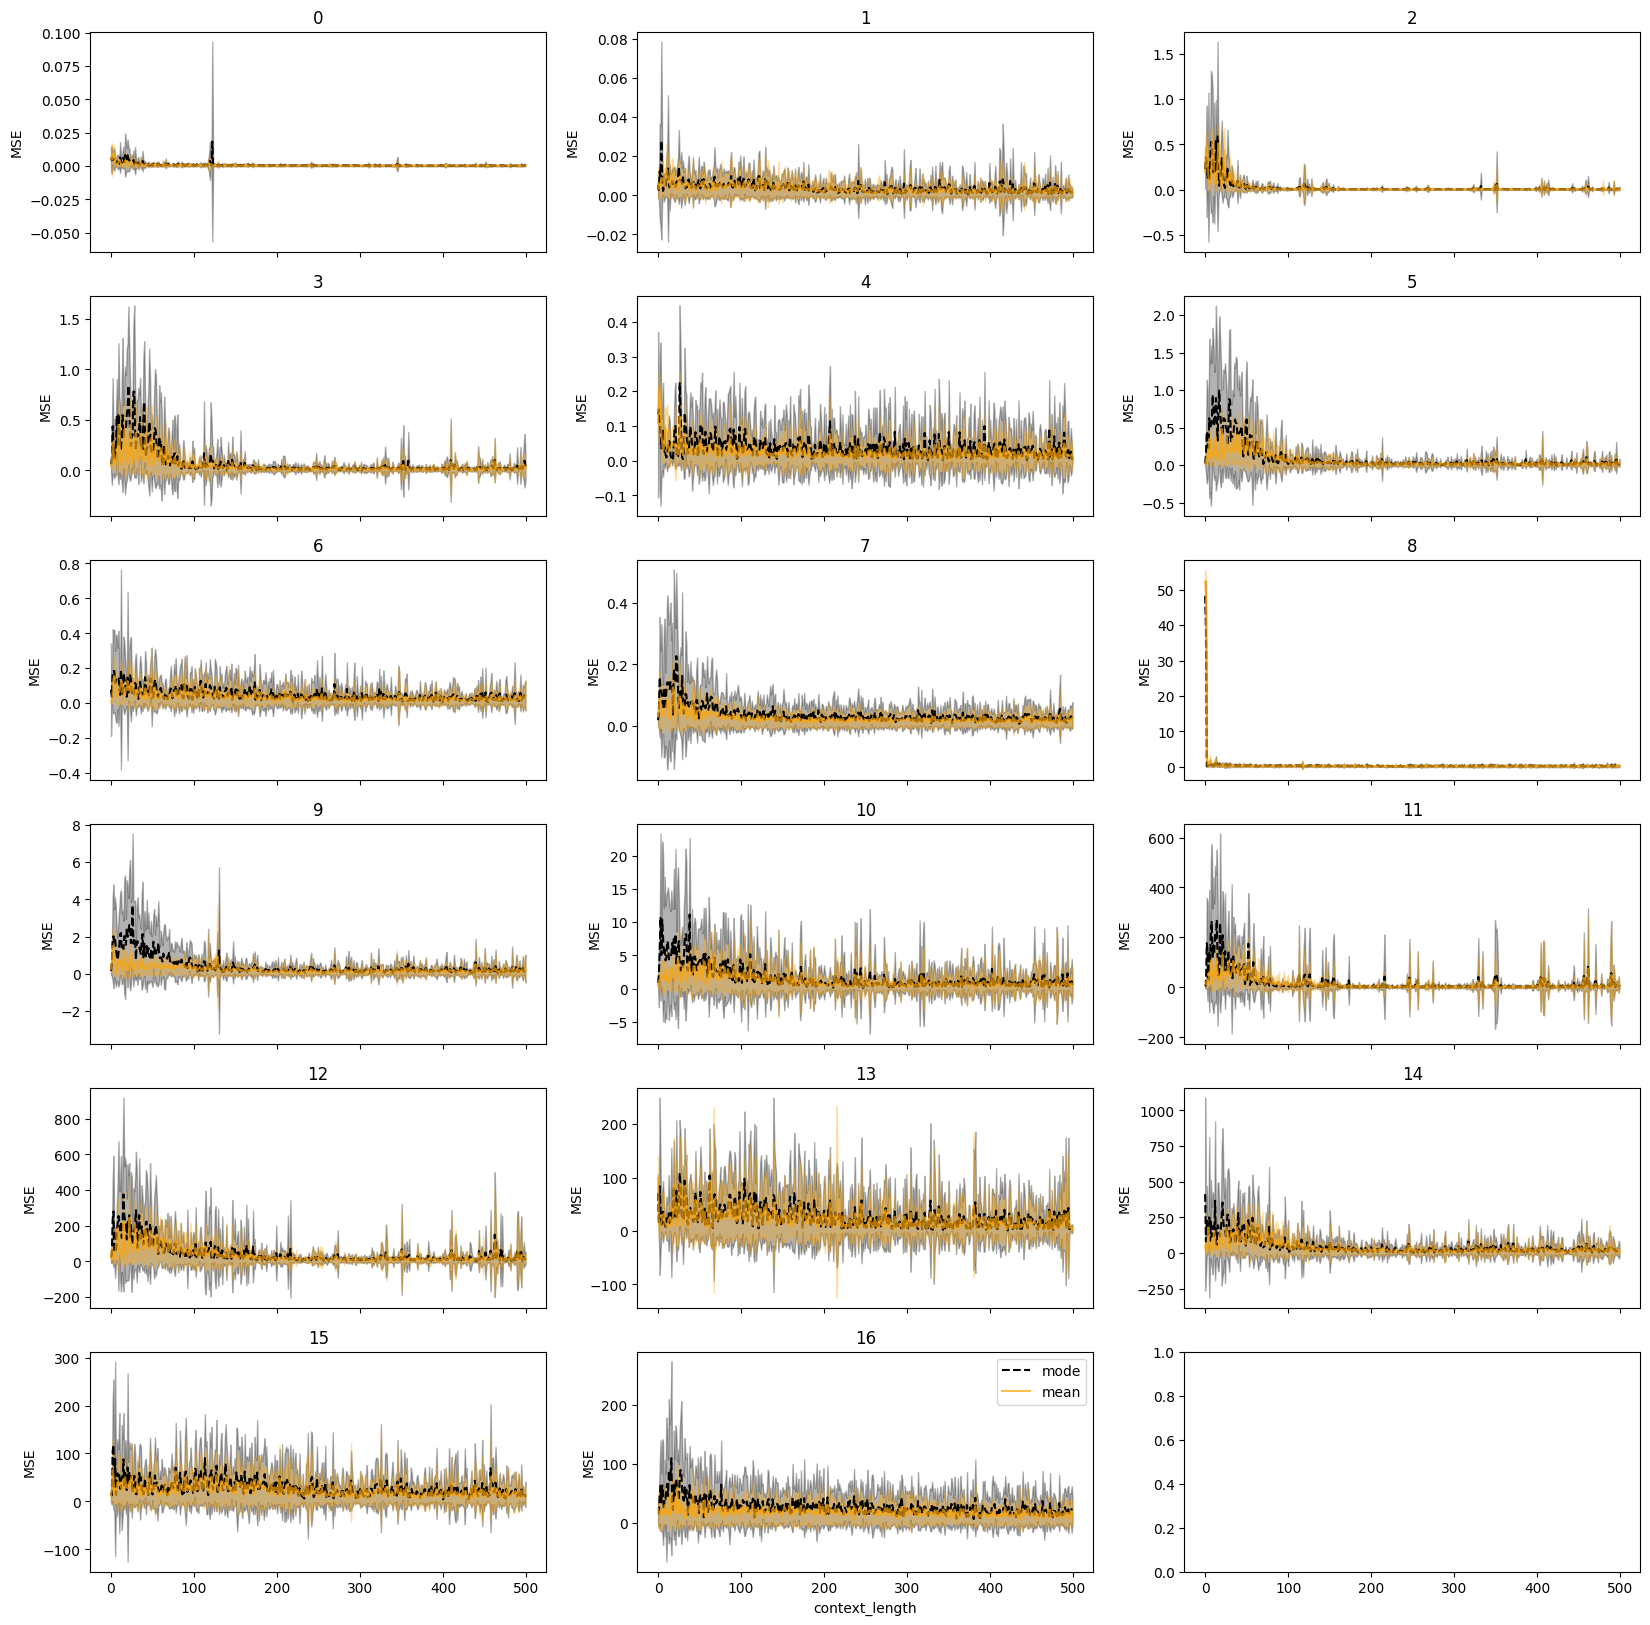

In [16]:
groundtruth_all = []
for episode in tqdm(episode_starts, desc='episode'):
    groundtruth_all.append(X[episode+1:episode+context_length+1, :n_observations][None, ...])
groundtruth_all = np.concatenate(groundtruth_all, axis=0)

f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.2}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = groundtruth_all[:, :, dim]
    
    # -------------------- Useful for Plots --------------------
    mean_arr_all = [
        (((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (icl_object[dim].rescaling_max - icl_object[dim].rescaling_min)
         + icl_object[dim].rescaling_min)[None,...]
        for icl_object in icl_objects_list
    ]
    mean_arr_all = np.concatenate(mean_arr_all, axis=0)
    
    mode_arr_all = [
        (((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (icl_object[dim].rescaling_max - icl_object[dim].rescaling_min)
         + icl_object[dim].rescaling_min)[None,...]
        for icl_object in icl_objects_list
    ]
    mode_arr_all = np.concatenate(mode_arr_all, axis=0)
    
    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr_all.shape[1])
    mean_error = np.power(groundtruth-mean_arr_all, 2)
    mode_error = np.power(groundtruth-mode_arr_all, 2)
    
    axes[dim].plot(x, mode_error.mean(axis=0), 'k--',label='mode')
    axes[dim].fill_between(
        x=x, 
        y1=mode_error.mean(axis=0)-mode_error.std(axis=0), 
        y2=mode_error.mean(axis=0)+mode_error.std(axis=0),
        color='k',
        alpha=.3,
    )
    axes[dim].plot(x, mean_error.mean(axis=0), label='mean', color='orange', alpha=.7)
    axes[dim].fill_between(
        x=x, 
        y1=mean_error.mean(axis=0)-mean_error.std(axis=0), 
        y2=mean_error.mean(axis=0)+mean_error.std(axis=0),
        color='orange',
        alpha=.3
    )
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("context_length")
    axes[dim].set_ylabel("MSE")
axes[dim].legend()
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()

## baselines

In [25]:
sub_context_size_list = [10, 100, 250, 399]

linreg_pred_all_episodes = []
linreg_actions_pred_all_episodes = []
mlp_pred_all_episodes = []
mlp_actions_pred_all_episodes = []
for episode in tqdm(episode_starts, desc='episode'):
    linreg_pred_all = []
    linreg_actions_pred_all = []
    mlp_pred_all = []
    mlp_actions_pred_all = []
    for sub_context_size in sub_context_size_list:
        X_train_actions = copy.copy(
            np.concatenate(
                [
                    X[episode:episode+sub_context_size, :n_observations],
                    X[episode:episode+sub_context_size, n_observations+1 : n_observations + n_actions+1],
                ],
                axis=1,
            )[:-1]
        )  # TODO: halfcheetah have obs_reward as additional obs
        X_train = copy.copy(X[episode:episode+sub_context_size-1, :n_observations])
        y_train = copy.copy(X[episode+1:episode+sub_context_size, :n_observations])
        
        nan_indices = np.unique(np.argwhere(np.isnan(X_train_actions))[:, 0])
        mask = np.ones(X_train_actions.shape[0], bool)
        mask[nan_indices] = False
        
        X_train = X_train[mask]
        X_train_actions = X_train_actions[mask]
        y_train = y_train[mask]
        
        # ------- Fit Linear regression -------
        linreg_model = LinearRegression(fit_intercept=True)
        linreg_model.fit(X_train, y_train)
        linreg_input = X[
            episode+sub_context_size-1,
            :n_observations,
        ]
        linreg_pred_all.append(linreg_model.predict(linreg_input[None, ...]))

        # ------- Fit Linear regression with actions -------
        linreg_model = LinearRegression(fit_intercept=True)
        linreg_model.fit(X_train_actions, y_train)
        linreg_input = np.concatenate(
            [
                X[episode+sub_context_size-1, :n_observations][None, ...],
                X[episode+sub_context_size-1, n_observations+1 : n_observations + n_actions+1][None, ...],
            ],
            axis=1,
        )
        linreg_actions_pred_all.append(linreg_model.predict(linreg_input))

        # ------- Fit MLP -------
        mlp = nn_utils.NeuralNet(input_size=n_observations, output_size=n_observations)
        _, _, mlp = nn_utils.train_mlp(model=mlp, X_train=X_train, y_train=y_train)
        mlp.eval()
        mlp_input = X[
            episode+sub_context_size-1,
            :n_observations,
        ]
        mlp_pred = (
            mlp(torch.from_numpy(mlp_input[None, ...]).type(torch.FloatTensor)).cpu().detach().numpy()
        )
        mlp_pred_all.append(mlp_pred)

        # ------- Fit MLP with actions -------
        mlp_actions = nn_utils.NeuralNet(
            input_size=n_observations + n_actions, output_size=n_observations
        )
        _, _, mlp_actions = nn_utils.train_mlp(
            model=mlp_actions, X_train=X_train_actions, y_train=y_train
        )
        mlp_actions.eval()
        mlp_input_actions = np.concatenate(
            [
                X[episode+sub_context_size-1, :n_observations][None, ...],
                X[episode+sub_context_size-1, n_observations+1 : n_observations + n_actions+1][None, ...],
            ],
            axis=1,
        )
        mlp_actions_pred = (
            mlp_actions(torch.from_numpy(mlp_input_actions).type(torch.FloatTensor))
            .cpu()
            .detach()
            .numpy()
        )
        mlp_actions_pred_all.append(mlp_actions_pred)

    linreg_pred_all_episodes.append(np.concatenate(linreg_pred_all, axis=0)[None, ...])
    linreg_actions_pred_all_episodes.append(np.concatenate(linreg_actions_pred_all, axis=0)[None, ...])
    mlp_pred_all_episodes.append(np.concatenate(mlp_pred_all, axis=0)[None, ...])
    mlp_actions_pred_all_episodes.append(np.concatenate(mlp_actions_pred_all, axis=0)[None, ...])

linreg_pred_all_episodes = np.concatenate(linreg_pred_all_episodes, axis=0)
linreg_actions_pred_all_episodes = np.concatenate(linreg_actions_pred_all_episodes, axis=0)
mlp_pred_all_episodes = np.concatenate(mlp_pred_all_episodes, axis=0)
mlp_actions_pred_all_episodes = np.concatenate(mlp_actions_pred_all_episodes, axis=0)

episode: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 19/19 [02:31<00:00,  7.96s/it]


## final vizu

episode: 100%|███████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 148678.69it/s]


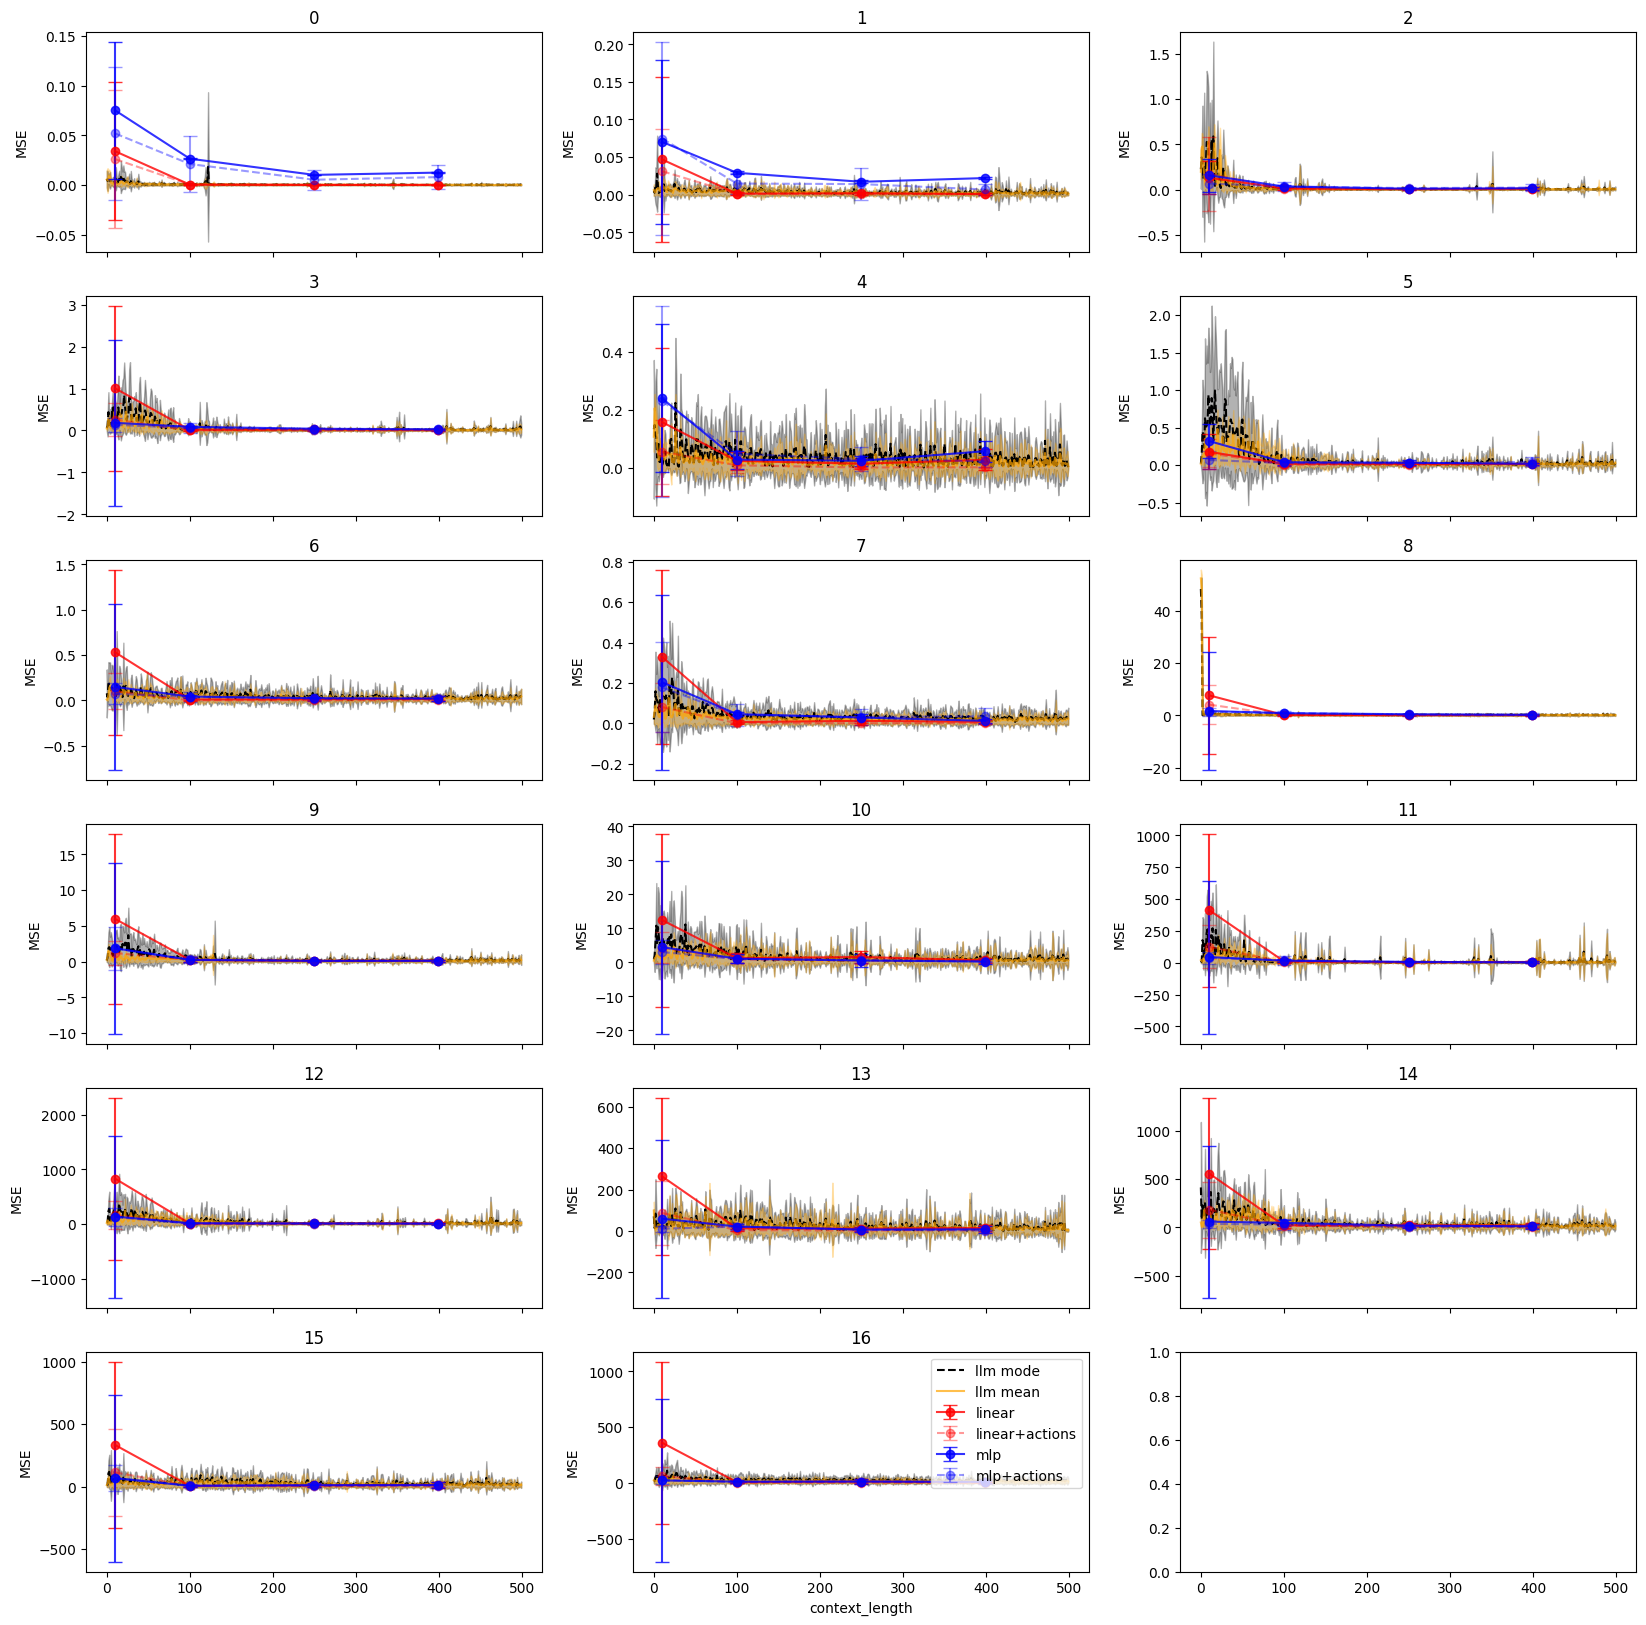

In [27]:
groundtruth = []
for episode in tqdm(episode_starts, desc='episode'):
    groundtruth.append(X[episode+1:episode+context_length+1, :n_observations][None, ...])
groundtruth = np.concatenate(groundtruth, axis=0)

f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.2}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    # -------------------- Useful for Plots --------------------
    mean_arr_all = [
        (((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (icl_object[dim].rescaling_max - icl_object[dim].rescaling_min) + 
         icl_object[dim].rescaling_min)[None,...]
        for icl_object in icl_objects_list
    ]
    mean_arr_all = np.concatenate(mean_arr_all, axis=0)
    
    mode_arr_all = [
        (((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (icl_object[dim].rescaling_max - icl_object[dim].rescaling_min) + 
         icl_object[dim].rescaling_min)[None,...]
        for icl_object in icl_objects_list
    ]
    mode_arr_all = np.concatenate(mode_arr_all, axis=0)
    
    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr_all.shape[1])
    mean_error = np.power(groundtruth[:, :, dim]-mean_arr_all, 2)
    mode_error = np.power(groundtruth[:, :, dim]-mode_arr_all, 2)
    
    axes[dim].plot(x, mode_error.mean(axis=0), 'k--',label='llm mode')
    axes[dim].fill_between(
        x=x, 
        y1=mode_error.mean(axis=0)-mode_error.std(axis=0), 
        y2=mode_error.mean(axis=0)+mode_error.std(axis=0),
        color='k',
        alpha=.3,
    )
    axes[dim].plot(x, mean_error.mean(axis=0), label='llm mean', color='orange', alpha=.7)
    axes[dim].fill_between(
        x=x, 
        y1=mean_error.mean(axis=0)-mean_error.std(axis=0), 
        y2=mean_error.mean(axis=0)+mean_error.std(axis=0),
        color='orange',
        alpha=.3
    )
    # -------------------- Baselines --------------------
    # ------- Linear ----------
    linreg_error = np.power(
        linreg_pred_all_episodes[:,:,dim] - groundtruth[:,[scs-1 for scs in sub_context_size_list],dim], 
        2
    )
    linreg_actions_error = np.power(
        linreg_actions_pred_all_episodes[:,:,dim] - groundtruth[:,[scs-1 for scs in sub_context_size_list],dim], 
        2
    )
    axes[dim].errorbar(
        sub_context_size_list, 
        linreg_error.mean(axis=0), 
        yerr=linreg_error.std(axis=0), 
        fmt='o-', 
        color='red', 
        ecolor='red', 
        capsize=5, 
        label='linear',
        alpha=.8
    )
    axes[dim].errorbar(
        sub_context_size_list, 
        linreg_actions_error.mean(axis=0), 
        yerr=linreg_actions_error.std(axis=0), 
        fmt='o--', 
        color='red', 
        ecolor='red', 
        capsize=5, 
        label='linear+actions',
        alpha=.4
    )
    # ------- MLP ----------
    mlp_error = np.power(
        mlp_pred_all_episodes[:,:,dim] - groundtruth[:,[scs-1 for scs in sub_context_size_list],dim], 
        2
    )
    mlp_actions_error = np.power(
        mlp_actions_pred_all_episodes[:,:,dim] - groundtruth[:,[scs-1 for scs in sub_context_size_list],dim], 
        2
    )
    axes[dim].errorbar(
        sub_context_size_list, 
        mlp_error.mean(axis=0), 
        yerr=linreg_error.std(axis=0), 
        fmt='o-', 
        color='blue', 
        ecolor='blue', 
        capsize=5, 
        label='mlp',
        alpha=.8
    )
    axes[dim].errorbar(
        sub_context_size_list, 
        mlp_actions_error.mean(axis=0), 
        yerr=mlp_actions_error.std(axis=0), 
        fmt='o--', 
        color='blue', 
        ecolor='blue', 
        capsize=5, 
        label='mlp+actions',
        alpha=.4
    )
    
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("context_length")
    axes[dim].set_ylabel("MSE")
axes[dim].legend()
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()

# Multi-step prediction

## llm

In [10]:
n_episodes = 5
context_length = 200
prediction_horizon = 20
rescale_factor = 7.0
up_shift = 1.5

icl_objects_list = []

print(f"episode starts: {episode_starts}")
for episode in tqdm(episode_starts[:n_episodes], desc='episode'):
    time_series = X[episode:episode+context_length, :n_observations]
    
    trainer = trainers.RLICLTrainer(
        model=model,
        tokenizer=tokenizer,
        n_observations=n_observations,
        n_actions=n_actions,
        rescale_factor=rescale_factor,
        up_shift=up_shift,
    )
    
    trainer.update_context(
        time_series=copy.copy(time_series),
        mean_series=copy.copy(time_series),
        sigma_series=np.zeros_like(time_series),
        context_length=context_length,
        update_min_max=True,
    )
    
    trainer.icl(verbose=0, stochastic=True)

    icl_object = trainer.predict_long_horizon_llm(prediction_horizon=prediction_horizon, stochastic=True, verbose=0)

    icl_objects_list.append(icl_object)

episode starts: [    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000]


episode:   0%|                                                                                                     | 0/5 [00:00<?, ?it/s]/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:446: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr
episode: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [42:29<00:00, 509.91s/it]


## baselines

In [13]:
sub_context_size_list = [10, 50, 100, context_length-1]

linreg_pred_all_episodes = []
linreg_actions_pred_all_episodes = []
mlp_pred_all_episodes = []
mlp_actions_pred_all_episodes = []
for episode in tqdm(episode_starts[:n_episodes], desc='episode'):
    linreg_pred_all = []
    linreg_actions_pred_all = []
    mlp_pred_all = []
    mlp_actions_pred_all = []
    for i, sub_context_size in enumerate(sub_context_size_list):
        X_train_actions = copy.copy(
            np.concatenate(
                [
                    X[episode:episode+sub_context_size, :n_observations],
                    X[episode:episode+sub_context_size, n_observations+1 : n_observations + n_actions+1],
                ],
                axis=1,
            )[:-1]
        )  # TODO: halfcheetah have obs_reward as additional obs
        X_train = copy.copy(X[episode:episode+sub_context_size-1, :n_observations])
        y_train = copy.copy(X[episode+1:episode+sub_context_size, :n_observations])
        
        nan_indices = np.unique(np.argwhere(np.isnan(X_train_actions))[:, 0])
        mask = np.ones(X_train_actions.shape[0], bool)
        mask[nan_indices] = False
        
        X_train = X_train[mask]
        X_train_actions = X_train_actions[mask]
        y_train = y_train[mask]

        # ------- Fit Linear regression -------
        linreg_model = LinearRegression(fit_intercept=True)
        linreg_model.fit(X_train, y_train)

        # ------- Fit Linear regression with actions -------
        linreg_actions_model = LinearRegression(fit_intercept=True)
        linreg_actions_model.fit(X_train_actions, y_train)

        # ------- Fit MLP -------
        mlp = nn_utils.NeuralNet(input_size=n_observations, output_size=n_observations)
        _, _, mlp = nn_utils.train_mlp(model=mlp, X_train=X_train, y_train=y_train)
        mlp.eval()

        # ------- Fit MLP with actions -------
        mlp_actions = nn_utils.NeuralNet(
            input_size=n_observations + n_actions, output_size=n_observations
        )
        _, _, mlp_actions = nn_utils.train_mlp(
            model=mlp_actions, X_train=X_train_actions, y_train=y_train
        )
        mlp_actions.eval()

        # prediction single-step or multi-step
        if i < len(sub_context_size_list)-1:
            # ------- Linear regression -------
            linreg_input = X[
                episode+sub_context_size-1,
                :n_observations,
            ]
            linreg_pred = linreg_model.predict(linreg_input[None, ...])
            
            # ------- Linear regression with actions -------
            linreg_actions_input = np.concatenate(
                [
                    X[episode+sub_context_size-1, :n_observations][None, ...],
                    X[episode+sub_context_size-1, n_observations+1 : n_observations + n_actions+1][None, ...],
                ],
                axis=1,
            )
            linreg_actions_pred = linreg_actions_model.predict(linreg_actions_input)
    
            # ------- MLP -------
            mlp_input = X[
                episode+sub_context_size-1,
                :n_observations,
            ]
            mlp_pred = (
                mlp(torch.from_numpy(mlp_input[None, ...]).type(torch.FloatTensor)).cpu().detach().numpy()
            )
    
            # ------- MLP with actions -------
            mlp_input_actions = np.concatenate(
                [
                    X[episode+sub_context_size-1, :n_observations][None, ...],
                    X[episode+sub_context_size-1, n_observations+1 : n_observations + n_actions+1][None, ...],
                ],
                axis=1,
            )
            mlp_actions_pred = (
                mlp_actions(torch.from_numpy(mlp_input_actions).type(torch.FloatTensor))
                .cpu()
                .detach()
                .numpy()
            )
        else:
            # ------- Linear regression -------
            linreg_input = X[
                episode+sub_context_size-1: episode+sub_context_size-1 + prediction_horizon,
                :n_observations,
            ]
            linreg_pred = linreg_model.predict(linreg_input)
            for h in range(prediction_horizon-1):
                new_pred = linreg_model.predict(
                    linreg_pred[h][None, ...]
                )
                linreg_pred[h+1] = copy.copy(new_pred)
            linreg_pred = linreg_pred[[0,-1]]
            
            # ------- Linear regression with actions -------
            linreg_input = np.concatenate(
                [
                    X[episode+sub_context_size-1: episode+sub_context_size-1 + prediction_horizon, :n_observations],
                    X[episode+sub_context_size-1: episode+sub_context_size-1 + prediction_horizon, n_observations+1 : n_observations + n_actions+1],
                ],
                axis=1,
            )
            linreg_actions_pred = linreg_actions_model.predict(linreg_input)
            # multi-step prediction
            for h in range(prediction_horizon-1):
                # linear + actions
                new_input_actions = np.concatenate(
                    [
                        linreg_actions_pred[h][None, ...],
                        linreg_input[
                            h,
                            n_observations : n_observations + n_actions,
                        ][None, ...],
                        # TODO: halfcheetah have obs_reward as additional obs
                    ],
                    axis=1,
                )
                new_pred_actions = linreg_actions_model.predict(new_input_actions)
                linreg_actions_pred[h+1] = copy.copy(new_pred_actions)
            linreg_actions_pred = linreg_actions_pred[[0,-1]]
    
            # ------- MLP -------
            mlp_input = X[
                episode+sub_context_size-1: episode+sub_context_size-1 + prediction_horizon,
                :n_observations,
            ]
            mlp_pred = (
                mlp(torch.from_numpy(mlp_input).type(torch.FloatTensor)).cpu().detach().numpy()
            )
            for h in range(prediction_horizon-1):
                new_pred = mlp(torch.from_numpy(
                    mlp_pred[h][None, ...]
                ).type(torch.FloatTensor)).cpu().detach().numpy()
                mlp_pred[h+1] = copy.copy(new_pred)
            mlp_pred = mlp_pred[[0,-1]]
    
            # ------- MLP with actions -------
            mlp_input_actions = np.concatenate(
                [
                    X[episode+sub_context_size-1: episode+sub_context_size-1 + prediction_horizon, :n_observations],
                    X[episode+sub_context_size-1: episode+sub_context_size-1 + prediction_horizon, n_observations+1 : n_observations + n_actions+1],
                ],
                axis=1,
            )
            mlp_actions_pred = (
                mlp_actions(torch.from_numpy(mlp_input_actions).type(torch.FloatTensor))
                .cpu()
                .detach()
                .numpy()
            )
            # multi-step prediction
            for h in range(prediction_horizon-1):
                new_input_actions = np.concatenate(
                    [
                        mlp_actions_pred[h][None, ...],
                        mlp_input_actions[
                            h,
                            n_observations : n_observations + n_actions,
                        ][None, ...],
                        # TODO: halfcheetah have obs_reward as additional obs
                    ],
                    axis=1,
                )
                new_pred_actions = (
                    mlp_actions(torch.from_numpy(new_input_actions).type(torch.FloatTensor))
                    .cpu()
                    .detach()
                    .numpy()
                )
                mlp_actions_pred[h+1] = copy.copy(new_pred_actions)
            mlp_actions_pred = mlp_actions_pred[[0,-1]]
        
        linreg_pred_all.append(linreg_pred)
        linreg_actions_pred_all.append(linreg_actions_pred)
        mlp_pred_all.append(mlp_pred)
        mlp_actions_pred_all.append(mlp_actions_pred)

    linreg_pred_all_episodes.append(np.concatenate(linreg_pred_all, axis=0)[None, ...])
    linreg_actions_pred_all_episodes.append(np.concatenate(linreg_actions_pred_all, axis=0)[None, ...])
    mlp_pred_all_episodes.append(np.concatenate(mlp_pred_all, axis=0)[None, ...])
    mlp_actions_pred_all_episodes.append(np.concatenate(mlp_actions_pred_all, axis=0)[None, ...])

linreg_pred_all_episodes = np.concatenate(linreg_pred_all_episodes, axis=0)
linreg_actions_pred_all_episodes = np.concatenate(linreg_actions_pred_all_episodes, axis=0)
mlp_pred_all_episodes = np.concatenate(mlp_pred_all_episodes, axis=0)
mlp_actions_pred_all_episodes = np.concatenate(mlp_actions_pred_all_episodes, axis=0)

episode: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.65s/it]


## vizu

episode: 100%|███████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168126.11it/s]


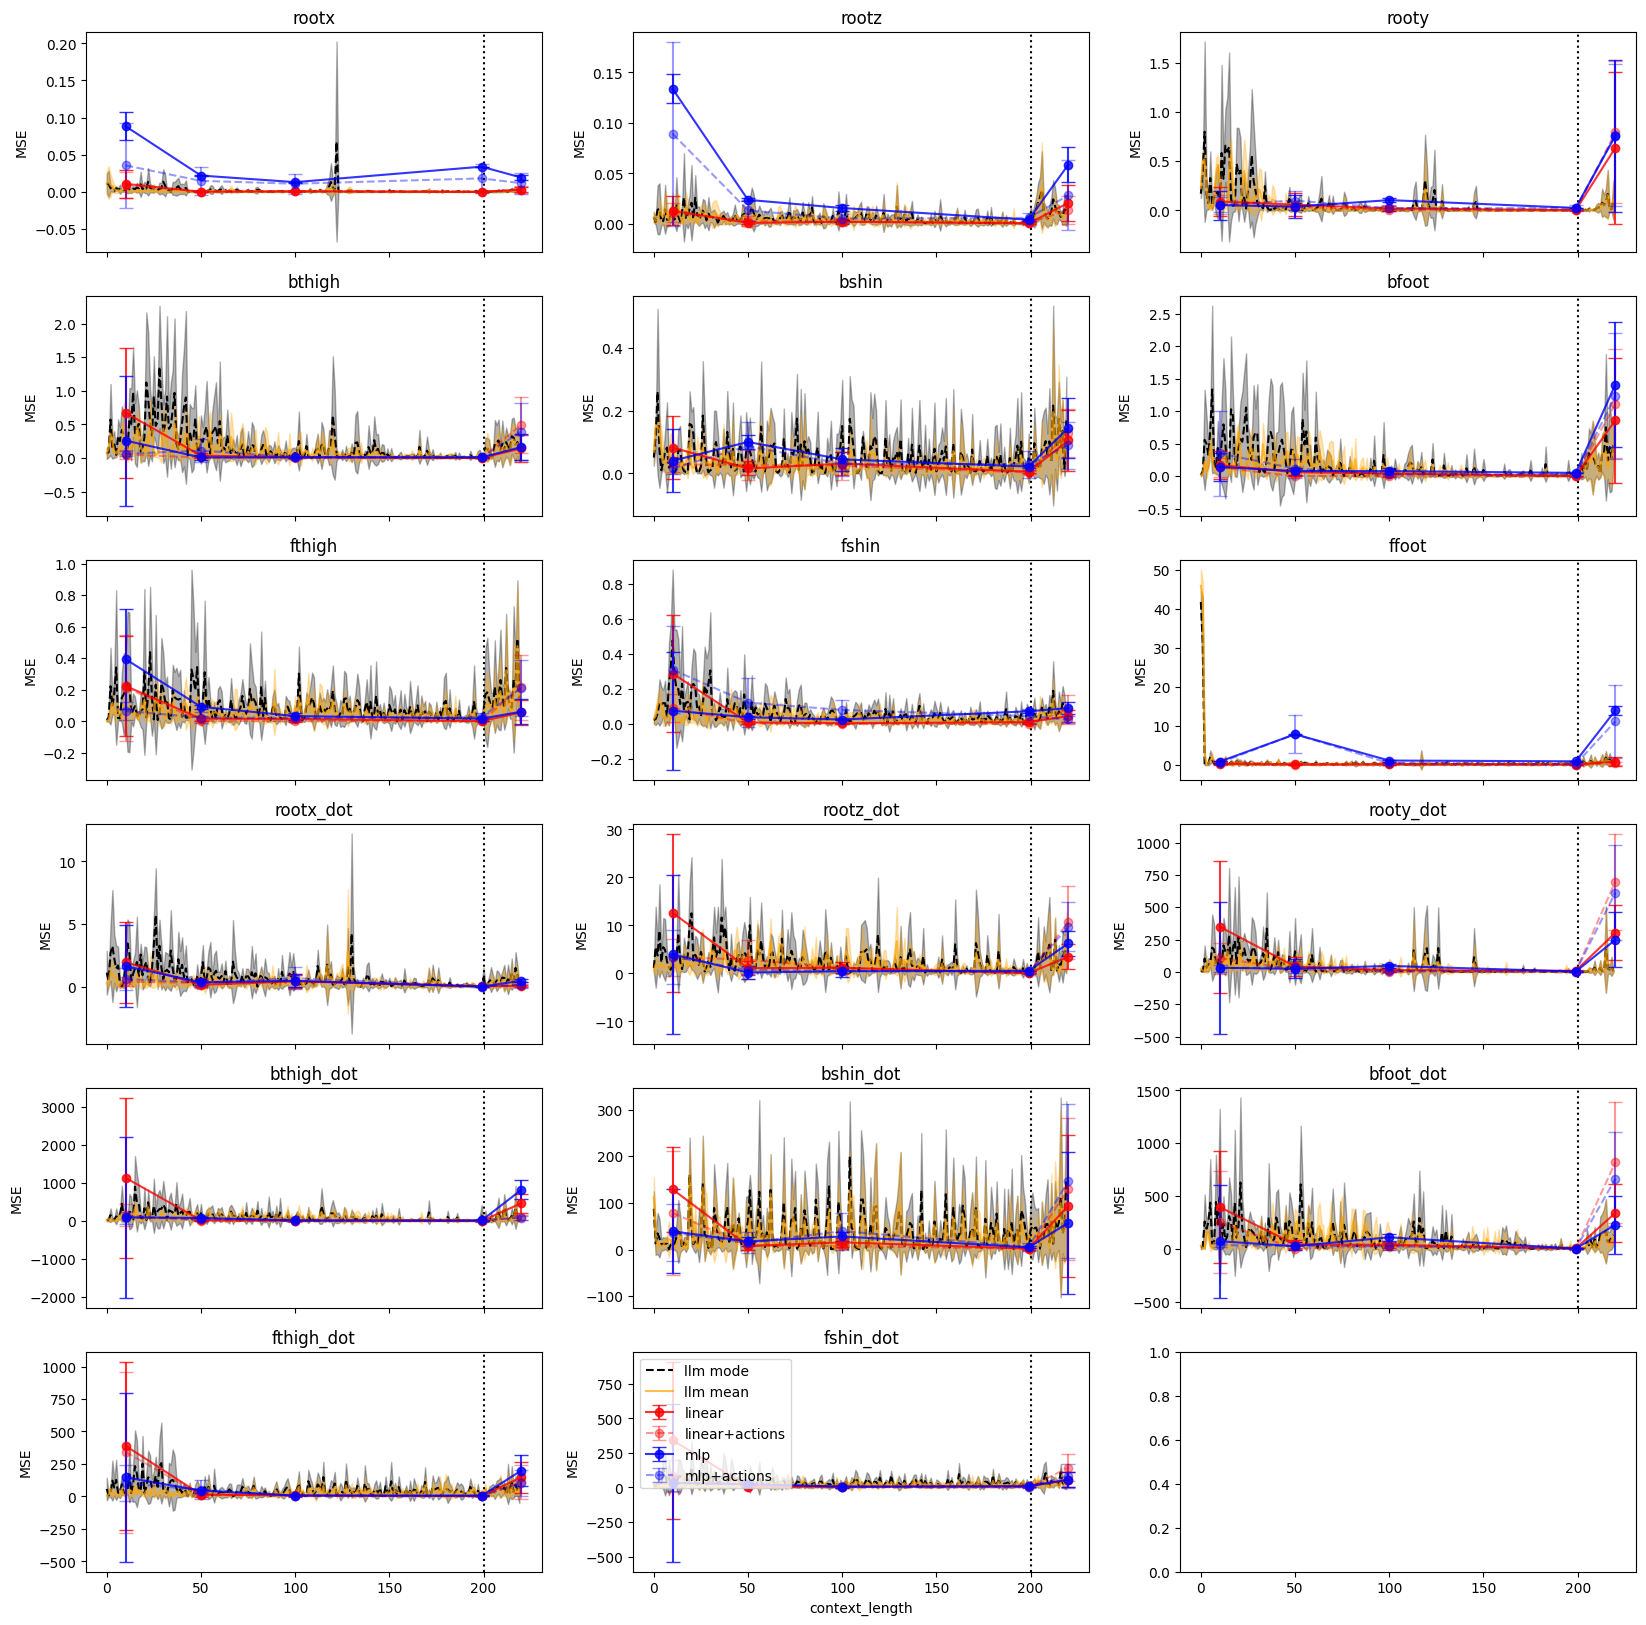

In [17]:
groundtruth = []
for episode in tqdm(episode_starts, desc='episode'):
    groundtruth.append(X[episode+1:episode+context_length+1+prediction_horizon, :n_observations][None, ...])
groundtruth = np.concatenate(groundtruth, axis=0)

f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.2}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    # -------------------- Useful for Plots --------------------
    mean_arr_all = [
        (((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (icl_object[dim].rescaling_max - icl_object[dim].rescaling_min) + 
         icl_object[dim].rescaling_min)[None,...]
        for icl_object in icl_objects_list
    ]
    mean_arr_all = np.concatenate(mean_arr_all, axis=0)
    
    mode_arr_all = [
        (((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (icl_object[dim].rescaling_max - icl_object[dim].rescaling_min) + 
         icl_object[dim].rescaling_min)[None,...]
        for icl_object in icl_objects_list
    ]
    mode_arr_all = np.concatenate(mode_arr_all, axis=0)
    
    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr_all.shape[1])
    mean_error = np.power(groundtruth[:n_episodes, :, dim]-mean_arr_all, 2)
    mode_error = np.power(groundtruth[:n_episodes, :, dim]-mode_arr_all, 2)
    
    axes[dim].plot(x, mode_error.mean(axis=0), 'k--',label='llm mode')
    axes[dim].fill_between(
        x=x, 
        y1=mode_error.mean(axis=0)-mode_error.std(axis=0), 
        y2=mode_error.mean(axis=0)+mode_error.std(axis=0),
        color='k',
        alpha=.3,
    )
    axes[dim].plot(x, mean_error.mean(axis=0), label='llm mean', color='orange', alpha=.7)
    axes[dim].fill_between(
        x=x, 
        y1=mean_error.mean(axis=0)-mean_error.std(axis=0), 
        y2=mean_error.mean(axis=0)+mean_error.std(axis=0),
        color='orange',
        alpha=.3
    )
    # -------------------- Baselines --------------------
    # ------- Linear ----------
    x_baselines = sub_context_size_list + [context_length+prediction_horizon]
    linreg_error = np.power(
        linreg_pred_all_episodes[:,:,dim] - groundtruth[:n_episodes,[scs-1 for scs in x_baselines],dim], 
        2
    )
    linreg_actions_error = np.power(
        linreg_actions_pred_all_episodes[:,:,dim] - groundtruth[:n_episodes,[scs-1 for scs in x_baselines],dim], 
        2
    )
    axes[dim].errorbar(
        x_baselines, 
        linreg_error.mean(axis=0), 
        yerr=linreg_error.std(axis=0), 
        fmt='o-', 
        color='red', 
        ecolor='red', 
        capsize=5, 
        label='linear',
        alpha=.8
    )
    axes[dim].errorbar(
        x_baselines, 
        linreg_actions_error.mean(axis=0), 
        yerr=linreg_actions_error.std(axis=0), 
        fmt='o--', 
        color='red', 
        ecolor='red', 
        capsize=5, 
        label='linear+actions',
        alpha=.4
    )
    # ------- MLP ----------
    mlp_error = np.power(
        mlp_pred_all_episodes[:,:,dim] - groundtruth[:n_episodes,[scs-1 for scs in x_baselines],dim], 
        2
    )
    mlp_actions_error = np.power(
        mlp_actions_pred_all_episodes[:,:,dim] - groundtruth[:n_episodes,[scs-1 for scs in x_baselines],dim], 
        2
    )
    axes[dim].errorbar(
        x_baselines, 
        mlp_error.mean(axis=0), 
        yerr=linreg_error.std(axis=0), 
        fmt='o-', 
        color='blue', 
        ecolor='blue', 
        capsize=5, 
        label='mlp',
        alpha=.8
    )
    axes[dim].errorbar(
        x_baselines, 
        mlp_actions_error.mean(axis=0), 
        yerr=mlp_actions_error.std(axis=0), 
        fmt='o--', 
        color='blue', 
        ecolor='blue', 
        capsize=5, 
        label='mlp+actions',
        alpha=.4
    )

    axes[dim].axvline(x=context_length, color="black", linestyle=":")
    axes[dim].set_title(f"{state_names[env_name][dim]}")
    if dim > 15:
        axes[dim].set_xlabel("context_length")
    axes[dim].set_ylabel("MSE")
axes[dim].legend()
plt.savefig(f"/home/abenechehab/llmicl/src/llmicl/artifacts/figures/baselines|{env_name}.png")
plt.show()

## Radar chrt

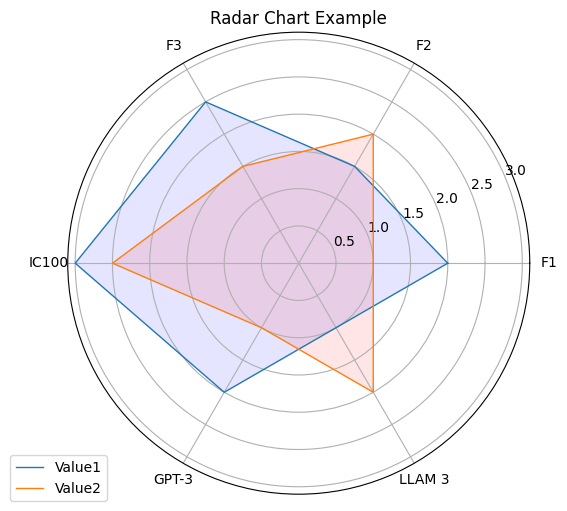

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Arc

# Example synthetic data
data = {
    'Category': ['F1', 'F2', 'F3', 'IC100', 'GPT-3', 'LLAM 3'],
    'Value1': [2.0, 1.5, 2.5, 3.0, 2.0, 1.0],
    'Value2': [1.0, 2.0, 1.5, 2.5, 1.0, 2.0]
}

df = pd.DataFrame(data)

# Number of variables
categories = list(df['Category'])
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# First dataset
values = df['Value1'].tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='Value1')
ax.fill(angles, values, 'b', alpha=0.1)

# Second dataset
values = df['Value2'].tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='Value2')
ax.fill(angles, values, 'r', alpha=0.1)

# Add a thick arc for half the circle
# start_angle = 0  # Starting angle in degrees
# end_angle = start_angle + 30  # Ending angle (180 degrees from start)
# arc = Arc((0, 0), 6.4, 6.4, theta1=start_angle, theta2=end_angle, color='purple', linewidth=5, label='cat1')
# ax.add_patch(arc)

# Add a thick arc around the circle
# arc_colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan']
# for i in range(N):
# start_angle = angles[i]
# end_angle = angles[i + 1]
# arc = plt.Circle((0, 0), 3.2, transform=ax.transData._b, color='purple', linewidth=25, fill=False)
# ax.add_patch(arc)

# Add labels
plt.xticks(angles[:-1], categories)

# Add a title
plt.title('Radar Chart Example')

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()
